<img src="IMG/logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales - Segundo Cuatrimestre 2025

# TS4: Primeras nociones de estimación espectral 
#### Matías Cassino y Tomás Altimare

# Consignas

Comenzaremos con la generación de la siguiente señal:

- $ x(k)=a_0⋅sen(Ω_1⋅n)+na(n) $ siendo $ a_0=2 $, $ Ω_1=Ω_0+fr⋅2π/N $ y $ Ω_0=π2 $

siendo la variable aleatoria definida por la siguiente distribución de probabilidad

- $ f_r∼U(−2,2)$ y $na∼N(0,σ^2) $

Diseñe los siguientes estimadores,  de amplitud a1:

- $ \hat{a}^i_1=|X^i_w(Ω_0)|=|F{x(n)⋅w_i(n)}| $

 y de frecuencia Ω1:  
 
- $ \hat{Ω}^i_1=arg max_f{|X^i_w(Ω)|} $

para cada una de las ventanas: rectangular (sin ventana), flattop, blackmanharris y otra que elija de scipy.signal.windows

Y siguiendo las siguientes consignas para su experimentación:

Considere 200 realizaciones (muestras tomadas de fr) de 1000 muestras para cada experimento.
Parametrice para SNR's de 3 y 10 db (Ayuda: calibre a1 para que la potencia de la senoidal sea 1 W).

Se pide:

1) Realizar una tabla por cada SNR, que describa el sesgo y la varianza de cada estimador para cada ventana analizada. 
Recuerde incluir las ventanas rectangular (sin ventana), flattop y blackmanharris y otras que considere.

Ayuda: Puede calcular experimentalmente el sesgo y la varianza de un estimador:

$\hat{a}_0=|X^i_w(Ω_0)|$ siendo $s_a=E({\hat{a}_0})−a_0$ y $v_a=var({\hat{a}_0})=E({(\hat{a}_0−E({\hat{a}_0}))^2})$

y pueden aproximarse cuando consideramos los valores esperados como las medias muestrales

$E({\hat{a}_0})=\hat{μ}_a=(1/M)\sum_{j=0}^{M-1}\hat{a_j}$ -> $s_a=\hat{μ}_a−a_0$ y $v_a=(1/M)\sum_{j=0}^{M−1}(\hat{a}_j−\hat{μ}_a)^2$

Bonus:

 2) Analice el efecto del zero-padding para el estimador Ω^1
 
 3) Proponga estimadores alternativos para frecuencia y amplitud de la senoidal y repita el experimento.

 4) Visualizar los 3 histogramas juntos

# Introducción


# Desarrollo experimental

In [1]:
#%% Modulos
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pdsmodulos as pds
import scipy.signal as sig
import scipy.stats as st
from tabulate import tabulate

#%% Funciones
plt.close("all")

def mi_funcion_sen_estocastica_matricial(vmax, dc, ff, fr_matriz, realizaciones, ph, N, fs, plot=True):
    
    # Datos generales de la simulación
    ts = 1/fs # tiempo de muestreo
    tt = np.linspace(0, (N-1)*ts, N).reshape(-1,1) # grilla de sampleo temporal discreta (n) pasa de vector en 1xN a matriz NX1 (-1 toma el tamaño del último elemento)
    tt_matriz = np.tile(tt, (1, realizaciones))   #1000x200  pq tile replica array en columnas= repeticiones y filas =1 = no repitas
    omega_0=ff
    omega_1=(fs/N)*fr_matriz + omega_0
    arg = 2*np.pi*omega_1*tt_matriz + ph # argumento
    xx_matriz = (vmax*(np.sin(arg)) + dc) # señal
    var_x=np.var(xx_matriz)
    
    print(f'La varianza de la señal sin normalizar es: {var_x}\n')    
    if plot:
        
        #%% Presentación gráfica de los resultados
        plt.figure()
        plt.plot(tt_matriz, xx_matriz, label=f"f = {ff} Hz\nN = {N}\nTs = {ts} s\nPotencia = {var_x:.3} W")
        plt.title('Señal: senoidal')
        plt.xlabel('tiempo [s]')
        plt.ylabel('Amplitud [V]')
        plt.grid()
        plt.xlim([tt_matriz.min() - 0.1*(tt_matriz.max()-tt_matriz.min()), tt_matriz.max() + 0.1*(tt_matriz.max()-tt_matriz.min())])
        plt.ylim([xx_matriz.min() - 0.1*(xx_matriz.max()-xx_matriz.min()), xx_matriz.max() + 0.1*(xx_matriz.max()-xx_matriz.min())])
        plt.legend()
        plt.show() 
        
    return tt_matriz,xx_matriz


def mi_funcion_noise_matricial(N,SNR,media_n,realizaciones):
    var_n=10**(-SNR/10)
    med_n=media_n
    # n=np.random.normal(med_n, np.sqrt(var_n),N).reshape(-1,1)
    # n_matriz=np.tile(n, (1, realizaciones))
    n = np.random.normal(med_n, np.sqrt(var_n), (N, realizaciones))  # ruido independiente por realización
    n_matriz = n.reshape(N, realizaciones) # redundante
    var_n=np.var(n)
    print(f'La varianza del ruido con SRN={SNR} es: {var_n}\n')
    
    return n_matriz,var_n


def frecuencia_random_matricial(a,b,realizaciones):
    fr=np.random.uniform(a,b,realizaciones).reshape(1,-1) # 1x200
    fr_matriz=np.tile(fr, (N, 1)) #1000x200
    return fr_matriz

def normalizacion(x):
    media_x=np.mean(x) #media
    desvio_x=np.std(x) #desvio
    xx_norm=(x-media_x)/desvio_x #señal normalizada
    varianza_x=np.var(xx_norm) #varianza
    print(f'La varianza de la señal normalizada es: {varianza_x}\n')
    
    return xx_norm,varianza_x

def mod_y_fase_fft(fft_x):
    fft_x_abs=np.abs(fft_x)
    fft_x_abs_ph=np.max(np.angle(fft_x_abs))
    return fft_x_abs, fft_x_abs_ph

def estimadores(fft_abs_x,df,ff,N):
    k0= int(np.round(ff*(1/df))) # índice redondeado a entero de la fft que corresponde a ff
    a_estimadas=fft_abs_x[k0,:] # Vector de amplitudes en el índice de ff para c/realización
    index=np.argmax(fft_abs_x[:N//2],axis=0) # Vector de índices donde fft tiene máximo argumento para c/realización
    f_estimadas=index*df # Conversión de índice a frecuencia
    return f_estimadas,a_estimadas

def estadisticas(x_real,estimacion):
    media=np.mean(estimacion)
    sesgo=media-x_real
    varianza=np.var(estimacion)
    return sesgo,varianza

def estadisticas_robustas(x_real,estimacion):
    mediana=np.median(estimacion)
    sesgo=mediana-x_real
    mad=st.median_abs_deviation(estimacion, scale='normal') # Normal escala por sqrt(pi/2) para obtener un valor proporcional al desvío estándar para una distribución Gaussiana
    var_robusta=mad**2
    return sesgo,var_robusta

#%% Parámetros
N=1000 # cantidad de muestras
M=10*N # cantidad de muestras para zero padding
fs=1000 # frecuencia de muestreo
df=fs/N # resolución espectral
df_M=fs/M # resolución espectral para zero padding
k=np.arange(N)*df
k_M=np.arange(M)*df
ts = 1/fs # tiempo de muestreo
realizaciones=200 # parametro de fr
bins=15 # cantidad de bins
a_real=2 # Amplitud real
f_real=fs/4  # Frecuencia real

# Análisis de resultados

1) 

In [19]:
#%% Invocación de las funciones del punto 1
n_m_1,var_n_m_1=mi_funcion_noise_matricial(N=N,SNR=3,media_n=0,realizaciones=realizaciones)
n_m_2,var_n_m_2=mi_funcion_noise_matricial(N=N,SNR=10,media_n=0,realizaciones=realizaciones)

fr_m=frecuencia_random_matricial(a=-2,b=2,realizaciones=realizaciones)

t_m_1,x_m_1 = mi_funcion_sen_estocastica_matricial(vmax = 2, dc = 0, ff = fs/4, fr_matriz=fr_m, realizaciones=realizaciones, ph=0, N=N,fs=fs,plot=None)

# Normalización de señal
x_m_norm_1,var_m_norm_1=normalizacion(x_m_1)

# Señal normalizada con ruido
xn_m_1=x_m_norm_1+n_m_1

# Varianza de señal normalizada con ruido
var_xn_m_1=np.var(xn_m_1)

# Ventanas
w_bh=sig.windows.blackmanharris(N).reshape(-1,1)
w_bh_m=np.tile(w_bh, (1, realizaciones))

w_hamming=sig.windows.hamming(N).reshape(-1,1)
w_hamming_m=np.tile(w_hamming, (1, realizaciones))

w_flattop=sig.windows.flattop(N).reshape(-1,1)
w_flattop_m=np.tile(w_flattop, (1, realizaciones))

w_rectangular=sig.windows.get_window("boxcar",N).reshape(-1,1)
w_rectangular_m=np.tile(w_rectangular, (1, realizaciones))

# Señal normalizada con ruido ventaneada
xn_m_1_w_bh=xn_m_1*w_bh_m
xn_m_1_w_hamming=xn_m_1*w_hamming_m
xn_m_1_w_flattop=xn_m_1*w_flattop_m
xn_m_1_w_rectangular=xn_m_1*w_rectangular_m

# FFT normalizada por N
fft_xn_m_1_w_bh=np.fft.fft(xn_m_1_w_bh,axis=0)/N 
fft_xn_m_1_w_hamming=np.fft.fft(xn_m_1_w_hamming,axis=0)/N 
fft_xn_m_1_w_flattop=np.fft.fft(xn_m_1_w_flattop,axis=0)/N 
fft_xn_m_1_w_rectangular=np.fft.fft(xn_m_1_w_rectangular,axis=0)/N 

# Módulo y fase de FFT
fft_xn_m_1_w_bh_abs,fft_xn_m_1_w_bh_abs_ph=mod_y_fase_fft(fft_xn_m_1_w_bh)
fft_xn_m_1_w_hamming_abs,fft_xn_m_1_w_hamming_abs_ph=mod_y_fase_fft(fft_xn_m_1_w_hamming)
fft_xn_m_1_w_flattop_abs,fft_xn_m_1_w_flattop_abs_ph=mod_y_fase_fft(fft_xn_m_1_w_flattop)
fft_xn_m_1_w_rectangular_abs,fft_xn_m_1_w_rectangular_abs_ph=mod_y_fase_fft(fft_xn_m_1_w_rectangular)

# Estimadores de amplitud y frecuencia para c/ventana
f_estimado_1_xn_1_w_bh,a_estimado_1_xn_1_w_bh=estimadores(fft_xn_m_1_w_bh_abs,df=df,ff=fs/4,N=N)
f_estimado_1_xn_1_w_hamming,a_estimado_1_xn_1_w_hamming=estimadores(fft_xn_m_1_w_hamming_abs,df=df,ff=fs/4,N=N)
f_estimado_1_xn_1_w_flattop,a_estimado_1_xn_1_w_flattop=estimadores(fft_xn_m_1_w_flattop_abs,df=df,ff=fs/4,N=N)
f_estimado_1_xn_1_w_rectangular,a_estimado_1_xn_1_w_rectangular=estimadores(fft_xn_m_1_w_rectangular_abs,df=df,ff=fs/4,N=N)


La varianza del ruido con SRN=3 es: 0.5019638221494526

La varianza del ruido con SRN=10 es: 0.09964086501538097

La varianza de la señal sin normalizar es: 1.9989767816750998

La varianza de la señal normalizada es: 1.0000000000000002



In [33]:
# Presentación de los resultados del punto 1 para SNR=3
sesgo_a_bh,var_a_bh=estadisticas(a_real, a_estimado_1_xn_1_w_bh)
sesgo_f_bh,var_f_bh=estadisticas(f_real, f_estimado_1_xn_1_w_bh)

sesgo_a_hamming,var_a_hamming=estadisticas(a_real, a_estimado_1_xn_1_w_hamming)
sesgo_f_hamming,var_f_hamming=estadisticas(f_real, f_estimado_1_xn_1_w_hamming)

sesgo_a_flattop,var_a_flattop=estadisticas(a_real, a_estimado_1_xn_1_w_flattop)
sesgo_f_flattop,var_f_flattop=estadisticas(f_real, f_estimado_1_xn_1_w_flattop)

sesgo_a_rectangular,var_a_rectangular=estadisticas(a_real, a_estimado_1_xn_1_w_rectangular)
sesgo_f_rectangular,var_f_rectangular=estadisticas(f_real, f_estimado_1_xn_1_w_rectangular)

# ---- Tabla de valores en Amplitud ---- #
data_amplitud_punto_1 = [
    ["Blackman-Harris", f"{sesgo_a_bh:.3f}", f"{var_a_bh:.3e}"],
    ["Hamming", f"{sesgo_a_hamming:.3f}", f"{var_a_hamming:.3e}"],
    ["Flattop", f"{sesgo_a_flattop:.3f}", f"{var_a_flattop:.3e}"],
    ["Rectangular", f"{sesgo_a_rectangular:.3f}", f"{var_a_rectangular:.3e}"]
]

tabla_amplitud_punto_1 = tabulate(
    data_amplitud_punto_1,
    headers=["Ventana", "Sesgo", "Varianza"],
    tablefmt="fancy_grid",
    numalign="right",
    stralign="center",
    colalign=("center", "center", "center")
)
# ---- Tabla de valores en Frecuencia ---- #
data_frecuencia_punto_1 = [
    ["Blackman-Harris", f"{sesgo_f_bh:.3f}", f"{var_f_bh:.3e}"],
    ["Hamming", f"{sesgo_f_hamming:.3f}", f"{var_f_hamming:.3e}"],
    ["Flattop", f"{sesgo_f_flattop:.3f}", f"{var_f_flattop:.3e}"],
    ["Rectangular", f"{sesgo_f_rectangular:.3f}", f"{var_f_rectangular:.3e}"]
]

tabla_frecuencia_punto_1 = tabulate(
    data_frecuencia_punto_1,
    headers=["Ventana", "Sesgo", "Varianza"],
    tablefmt="fancy_grid",
    numalign="right",
    stralign="center",
    colalign=("center", "center", "center")
)

# ---- Imprimo las tablas ---- #
print("Tabla de valores en Amplitud")
print(tabla_amplitud_punto_1)
print("Tabla de valores en Frecuencia")
print(tabla_frecuencia_punto_1)

Tabla de valores en Amplitud
╒═════════════════╤═════════╤════════════╕
│     Ventana     │  Sesgo  │  Varianza  │
╞═════════════════╪═════════╪════════════╡
│ Blackman-Harris │ -1.836  │  0.004496  │
├─────────────────┼─────────┼────────────┤
│     Hamming     │ -1.826  │   0.0172   │
├─────────────────┼─────────┼────────────┤
│     Flattop     │  -1.86  │ 0.0003195  │
├─────────────────┼─────────┼────────────┤
│   Rectangular   │ -1.758  │  0.04857   │
╘═════════════════╧═════════╧════════════╛
Tabla de valores en Frecuencia
╒═════════════════╤═════════╤════════════╕
│     Ventana     │  Sesgo  │  Varianza  │
╞═════════════════╪═════════╪════════════╡
│ Blackman-Harris │  0.03   │   1.549    │
├─────────────────┼─────────┼────────────┤
│     Hamming     │  0.025  │   1.524    │
├─────────────────┼─────────┼────────────┤
│     Flattop     │ -0.005  │   1.475    │
├─────────────────┼─────────┼────────────┤
│   Rectangular   │  0.02   │    1.52    │
╘═════════════════╧═════════╧════════

- Amplitud:

  Por un lado, la varianza de la Flattop es la de menor magnitud y, simultaneamente, presenta el mayor sesgo. Esto se debe a que al posee el mayor lóbulo central en contraposición a las demás ventanas, este contiene más energía en su ancho de banda y el desparramo espectral es reducido.
  Por otro lado, la ventana rectangular exhibe la mayor varianza debido a que su distribución no es de carácter normal, sino uniforme, y tiene el menor lóbulo central pero los secundarios son los más amplios, por ende, mejora la resolución espectral e incrementa el desparramo de energía.
  Cabe destacar que todas las ventanas tienen sesgo negativo, por lo tanto, subestiman la amplitud verdadera de valor 2.

- Frecuencia:

  En este caso, todas las ventanas poseen sesgo positivo, es decir, sobrestiman el verdadero valor de frecuencia ubicado en fs/4.
  También, el estimador para la Flattop evidencia el menor sesgo y varianza, lo cual lo destaca frente a los demás correspondientes a otras ventanas.
  Paralelamente, la ventana rectangular y de Blackman-Harris exponen valores idénticos.
  

In [16]:
# Presentación de los resultados del punto 1 para SNR=10
sesgo_a_bh_2,var_a_bh_2=estadisticas(a_real, a_estimado_1_xn_2_w_bh)
sesgo_f_bh_2,var_f_bh_2=estadisticas(f_real, f_estimado_1_xn_2_w_bh)

sesgo_a_hamming_2,var_a_hamming_2=estadisticas(a_real, a_estimado_1_xn_2_w_hamming)
sesgo_f_hamming_2,var_f_hamming_2=estadisticas(f_real, f_estimado_1_xn_2_w_hamming)

sesgo_a_flattop_2,var_a_flattop_2=estadisticas(a_real, a_estimado_1_xn_2_w_flattop)
sesgo_f_flattop_2,var_f_flattop_2=estadisticas(f_real, f_estimado_1_xn_2_w_flattop)

sesgo_a_rectangular_2,var_a_rectangular_2=estadisticas(a_real, a_estimado_1_xn_2_w_rectangular)
sesgo_f_rectangular_2,var_f_rectangular_2=estadisticas(f_real, f_estimado_1_xn_2_w_rectangular)

# ---- Tabla de valores en Amplitud ---- #
data_amplitud_punto_2 = [
    ["Blackman-Harris", f"{sesgo_a_bh_2:.3f}", f"{var_a_bh_2:.3e}"],
    ["Hamming", f"{sesgo_a_hamming_2:.3f}", f"{var_a_hamming_2:.3e}"],
    ["Flattop", f"{sesgo_a_flattop_2:.3f}", f"{var_a_flattop_2:.3e}"],
    ["Rectangular", f"{sesgo_a_rectangular_2:.3f}", f"{var_a_rectangular_2:.3e}"]
]

tabla_amplitud_punto_2 = tabulate(
    data_amplitud_punto_2,
    headers=["Ventana", "Sesgo", "Varianza"],
    tablefmt="fancy_grid",
    numalign="right",
    stralign="center",
    colalign=("center", "center", "center")
)
# ---- Tabla de valores en Frecuencia ---- #
data_frecuencia_punto_2 = [
    ["Blackman-Harris", f"{sesgo_f_bh_2:.3f}", f"{var_f_bh_2:.3e}"],
    ["Hamming", f"{sesgo_f_hamming_2:.3f}", f"{var_f_hamming_2:.3e}"],
    ["Flattop", f"{sesgo_f_flattop_2:.3f}", f"{var_f_flattop_2:.3e}"],
    ["Rectangular", f"{sesgo_f_rectangular_2:.3f}", f"{var_f_rectangular_2:.3e}"]
]

tabla_frecuencia_punto_2 = tabulate(
    data_frecuencia_punto_2,
    headers=["Ventana", "Sesgo", "Varianza"],
    tablefmt="fancy_grid",
    numalign="right",
    stralign="center",
    colalign=("center", "center", "center")
)

# ---- Imprimo las tablas ---- #
print("Tabla de valores en Amplitud")
print(tabla_amplitud_punto_2)
print("Tabla de valores en Frecuencia")
print(tabla_frecuencia_punto_2)

Tabla de valores en Amplitud
╒═════════════════╤═════════╤════════════╕
│     Ventana     │  Sesgo  │  Varianza  │
╞═════════════════╪═════════╪════════════╡
│ Blackman-Harris │ -1.839  │  0.004389  │
├─────────────────┼─────────┼────────────┤
│     Hamming     │ -1.832  │  0.01777   │
├─────────────────┼─────────┼────────────┤
│     Flattop     │ -1.862  │ 0.0002642  │
├─────────────────┼─────────┼────────────┤
│   Rectangular   │ -1.755  │   0.0504   │
╘═════════════════╧═════════╧════════════╛
Tabla de valores en Frecuencia
╒═════════════════╤═════════╤════════════╕
│     Ventana     │  Sesgo  │  Varianza  │
╞═════════════════╪═════════╪════════════╡
│ Blackman-Harris │  -0.08  │   1.504    │
├─────────────────┼─────────┼────────────┤
│     Hamming     │  -0.08  │   1.514    │
├─────────────────┼─────────┼────────────┤
│     Flattop     │  -0.07  │   1.585    │
├─────────────────┼─────────┼────────────┤
│   Rectangular   │  -0.08  │   1.514    │
╘═════════════════╧═════════╧════════

- Amplitud:

  Se debe hacer hincapié en que prevalece la subestimación del valor verdadero a través de los sesgos negativos analogos a los obtenidos para SNR=3. A su vez, la varianza disminuye levemente para todas las ventanas.
  Nuevamente, la Flattop presenta la menor varianza y mayor sesgo en módulo, y, por el contrario, el estimador derivado de la ventana rectangular invierte tales relaciones respecto al sesgo y la varianza.

- Frecuencia:

  El estimador derivado de la ventana Hamming posee el menor sesgo y una varianza reducida y análoga a la perteneciente al estimador de la Flattop, que posee el mayor de los sesgos.

  En general, a diferencia de los resultados de las estadísticas de frecuencia para SNR=3, el sesgo se reduce mínimamente y la varianza mejora para la ventana rectangular y de Hamming.

2) 

In [5]:
#%% Invocación de las funciones del punto 2 para SNR=3
# FFT normalizada por N
fft_xn_m_1_w_bh_zp=np.fft.fft(xn_m_1_w_bh,M,axis=0)/N 
fft_xn_m_1_w_hamming_zp=np.fft.fft(xn_m_1_w_hamming,M,axis=0)/N 
fft_xn_m_1_w_flattop_zp=np.fft.fft(xn_m_1_w_flattop,M,axis=0)/N 
fft_xn_m_1_w_rectangular_zp=np.fft.fft(xn_m_1_w_rectangular,M,axis=0)/N 

# Módulo y fase de FFT
fft_xn_m_1_w_bh_abs_zp,fft_xn_m_1_w_bh_abs_ph_zp=mod_y_fase_fft(fft_xn_m_1_w_bh_zp)
fft_xn_m_1_w_hamming_abs_zp,fft_xn_m_1_w_hamming_abs_ph_zp=mod_y_fase_fft(fft_xn_m_1_w_hamming_zp)
fft_xn_m_1_w_flattop_abs_zp,fft_xn_m_1_w_flattop_abs_ph_zp=mod_y_fase_fft(fft_xn_m_1_w_flattop_zp)
fft_xn_m_1_w_rectangular_abs_zp,fft_xn_m_1_w_rectangular_abs_ph_zp=mod_y_fase_fft(fft_xn_m_1_w_rectangular_zp)

# Estimadores de amplitud y frecuencia para c/ventana
f_estimado_1_xn_1_w_bh_zp,_=estimadores(fft_xn_m_1_w_bh_abs_zp,df=df_M,ff=fs/4,N=M)
f_estimado_1_xn_1_w_hamming_zp,_=estimadores(fft_xn_m_1_w_hamming_abs_zp,df=df_M,ff=fs/4,N=M)
f_estimado_1_xn_1_w_flattop_zp,_=estimadores(fft_xn_m_1_w_flattop_abs_zp,df=df_M,ff=fs/4,N=M)
f_estimado_1_xn_1_w_rectangular_zp,_=estimadores(fft_xn_m_1_w_rectangular_abs_zp,df=df_M,ff=fs/4,N=M)

In [28]:
# Presentación de los resultados del punto 2 para SNR=3
sesgo_f_bh_zp,var_f_bh_zp=estadisticas(f_real, f_estimado_1_xn_1_w_bh_zp)
sesgo_f_hamming_zp,var_f_hamming_zp=estadisticas(f_real, f_estimado_1_xn_1_w_hamming_zp)
sesgo_f_flattop_zp,var_f_flattop_zp=estadisticas(f_real, f_estimado_1_xn_1_w_flattop_zp)
sesgo_f_rectangular_zp,var_f_rectangular_zp=estadisticas(f_real, f_estimado_1_xn_1_w_rectangular_zp)

# ---- Tabla de valores en frecuencia con Zero Padding ---- #
data_frecuencia_punto_zp = [
    ["Blackman-Harris", f"{sesgo_f_bh_zp:.3f}", f"{var_f_bh_zp:.3e}"],
    ["Hamming", f"{sesgo_f_hamming_zp:.3f}", f"{var_f_hamming_zp:.3e}"],
    ["Flattop", f"{sesgo_f_flattop_zp:.3f}", f"{var_f_flattop_zp:.3e}"],
    ["Rectangular", f"{sesgo_f_rectangular_zp:.3f}", f"{var_f_rectangular_zp:.3e}"]
]

tabla_frecuencia_punto_zp = tabulate(
    data_frecuencia_punto_zp,
    headers=["Ventana", "Sesgo", "Varianza"],
    tablefmt="fancy_grid",
    numalign="right",
    stralign="center",
    colalign=("center", "center", "center")
)

# ---- Imprimo la tabla ---- #
print("Tabla de valores con Zero Padding")
print(tabla_frecuencia_punto_zp)

Tabla de valores con Zero Padding
╒═════════════════╤═════════╤════════════╕
│     Ventana     │  Sesgo  │  Varianza  │
╞═════════════════╪═════════╪════════════╡
│ Blackman-Harris │ -0.075  │   1.419    │
├─────────────────┼─────────┼────────────┤
│     Hamming     │ -0.072  │   1.418    │
├─────────────────┼─────────┼────────────┤
│     Flattop     │ -0.064  │   1.607    │
├─────────────────┼─────────┼────────────┤
│   Rectangular   │ -0.074  │   1.416    │
╘═════════════════╧═════════╧════════════╛


- Frecuencia con Zero Padding:

  Se constata una disminución de la varianza y el sesgo en la mayoría de las ventanas excepto en la Flattop donde ambas medidas aumentan ya que esta aplica fundamentalmente a estimación de amplitud.
  En efecto, la técnica de zero padding al mejorar la resolución espectral artificialmente permite una estimación más precisa al reducirse la dispersión.
  Concretamente, el estimador obtenido de aplicar la ventana rectangular comprende la menor varianza, lo cual le brinda las características más idóneas.

3) 

In [35]:
#%% Presentación de los resultados del punto 3 para SNR=3
sesgo_robusto_a_bh,var_robusta_a_bh=estadisticas_robustas(a_real, a_estimado_1_xn_1_w_bh)
sesgo_robusto_f_bh,var_robusta_f_bh=estadisticas_robustas(f_real, f_estimado_1_xn_1_w_bh)

sesgo_robusto_a_hamming,var_robusta_a_hamming=estadisticas_robustas(a_real, a_estimado_1_xn_1_w_hamming)
sesgo_robusto_f_hamming,var_robusta_f_hamming=estadisticas_robustas(f_real, f_estimado_1_xn_1_w_hamming)

sesgo_robusto_a_flattop,var_robusta_a_flattop=estadisticas_robustas(a_real, a_estimado_1_xn_1_w_flattop)
sesgo_robusto_f_flattop,var_robusta_f_flattop=estadisticas_robustas(f_real, f_estimado_1_xn_1_w_flattop)

sesgo_robusto_a_rectangular,var_robusta_a_rectangular=estadisticas_robustas(a_real, a_estimado_1_xn_1_w_rectangular)
sesgo_robusto_f_rectangular,var_robusta_f_rectangular=estadisticas_robustas(f_real, f_estimado_1_xn_1_w_rectangular)

# ---- Tabla de valores en Amplitud ---- #
data_amplitud_punto_3 = [
    ["Blackman-Harris", f"{sesgo_robusto_a_bh:.3f}", f"{var_robusta_a_bh:.3e}"],
    ["Hamming", f"{sesgo_robusto_a_hamming:.3f}", f"{var_robusta_a_hamming:.3e}"],
    ["Flattop", f"{sesgo_robusto_a_flattop:.3f}", f"{var_robusta_a_flattop:.3e}"],
    ["Rectangular", f"{sesgo_robusto_a_rectangular:.3f}", f"{var_robusta_a_rectangular:.3e}"]
]

tabla_amplitud_punto_3 = tabulate(
    data_amplitud_punto_3,
    headers=["Ventana", "Sesgo", "MAD\u00b2"],
    tablefmt="fancy_grid",
    numalign="right",
    stralign="center",
    colalign=("center", "center", "center")
)
# ---- Tabla de valores en Frecuencia ---- #
data_frecuencia_punto_3 = [
    ["Blackman-Harris", f"{sesgo_robusto_f_bh:.3f}", f"{var_robusta_f_bh:.3e}"],
    ["Hamming", f"{sesgo_robusto_f_hamming:.3f}", f"{var_robusta_f_hamming:.3e}"],
    ["Flattop", f"{sesgo_robusto_f_flattop:.3f}", f"{var_robusta_f_flattop:.3e}"],
    ["Rectangular", f"{sesgo_robusto_f_rectangular:.3f}", f"{var_robusta_f_rectangular:.3e}"]
]

tabla_frecuencia_punto_3 = tabulate(
    data_frecuencia_punto_3,
    headers=["Ventana", "Sesgo", "MAD\u00b2"],
    tablefmt="fancy_grid",
    numalign="right",
    stralign="center",
    colalign=("center", "center", "center")
)

# ---- Imprimo las tablas ---- #
print("Tabla de valores en Amplitud")
print(tabla_amplitud_punto_3)
print("Tabla de valores en Frecuencia")
print(tabla_frecuencia_punto_3)

Tabla de valores en Amplitud
╒═════════════════╤═════════╤═══════════╕
│     Ventana     │  Sesgo  │   MAD²    │
╞═════════════════╪═════════╪═══════════╡
│ Blackman-Harris │ -1.832  │ 0.008305  │
├─────────────────┼─────────┼───────────┤
│     Hamming     │ -1.841  │  0.03497  │
├─────────────────┼─────────┼───────────┤
│     Flattop     │ -1.855  │ 0.0002496 │
├─────────────────┼─────────┼───────────┤
│   Rectangular   │ -1.858  │  0.0148   │
╘═════════════════╧═════════╧═══════════╛
Tabla de valores en Frecuencia
╒═════════════════╤═════════╤════════╕
│     Ventana     │  Sesgo  │  MAD²  │
╞═════════════════╪═════════╪════════╡
│ Blackman-Harris │    0    │ 2.198  │
├─────────────────┼─────────┼────────┤
│     Hamming     │    0    │ 2.198  │
├─────────────────┼─────────┼────────┤
│     Flattop     │    0    │ 2.198  │
├─────────────────┼─────────┼────────┤
│   Rectangular   │    0    │ 2.198  │
╘═════════════════╧═════════╧════════╛


Hasta el momento, los estimadores de sesgo y varianza de los distintos histogramas se basaron en el valor medio de las distintas ventanas. Para este análisis comparativo se utilizó la mediana como un método estadístico más robusto que el mostrado anteriormente. Se posiciona como un "estimador robusto" debido a que tiene una menor sensibilidad a valores atípicos en comparación a la media.

- Amplitud
    Como se puede observar, los valores dados de sesgo y MAD² (Median Absolute Desviation, que cuadrado equivale a una "varianza") para este caso, siguen siendo del mismo orden que los estimados a partir del valor medio. Se puede observar que, como en los anteriores casos, prevalece la subestimación del valor verdadero. A su vez, se sigue observando que la ventanan Flattop presenta la menor varianza.
  
- Frecuencia
    A comparación de los resultados en amplitud, se puede observar una gran diferencia en el orden de los valores estimados para sesgo y MAD². Como se puede apreciar, las ventanas se encuentran insesgadas, por lo que se encuentran centradas en el valor real al cual uno apunta estimar, mientras que el valor del MAD² es mucho mayor en comparación a los valores obtenidos con el anterior estimador.

En conclusión, el uso de la mediana como un estimador más robusto fue parcialmente comprobado para el dominio frecuencial, siendo que se consiguió insesgar las ventanas, pero pagando el precio de una varianza mayor, más no se encontraron diferencias en el dominio del tiempo (o "amplitud").

4) 

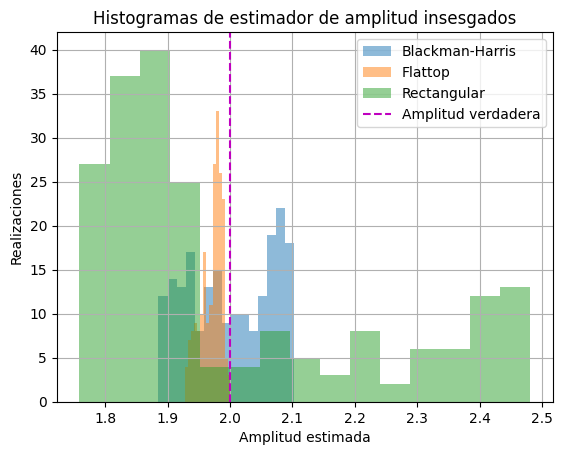

In [8]:
#%% Presentación gráfica de los resultados del punto 4 para SNR=3
plt.figure()
plt.hist(a_estimado_1_xn_1_w_bh-sesgo_a_bh, bins, alpha=0.5, label='Blackman-Harris')
plt.hist(a_estimado_1_xn_1_w_flattop-sesgo_a_hamming, bins, alpha=0.5, label='Flattop')
plt.hist(a_estimado_1_xn_1_w_rectangular-sesgo_a_rectangular, bins, alpha=0.5, label='Rectangular')
plt.axvline(np.mean(a_real), color='m', linestyle='--', label='Amplitud verdadera') # Línea vertical indicando valor verdadero de amplitud
plt.title("Histogramas de estimador de amplitud insesgados")
plt.xlabel("Amplitud estimada")
plt.ylabel("Realizaciones")
plt.legend()
plt.grid()
plt.show()

Como fue comentado anteriormente, se puede apreciar la diferencia de varianza entre las ventanas, siendo las de menor varianza las que contienen un espectro de menor volúmen (como la Flattop) y las de mayor varianza las que contienen un espectro con mayor volúmen (como la rectangular).

A su vez, se puede observar perfectamente en casos como la "Flattop", donde el sesgo es negativo, como es que la ventana subestima el valor real.

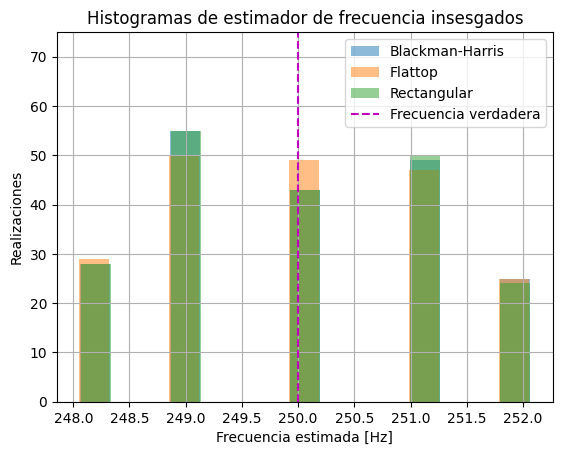

In [9]:
plt.figure()
plt.hist(f_estimado_1_xn_1_w_bh-sesgo_f_bh, bins, alpha=0.5, label='Blackman-Harris')
plt.hist(f_estimado_1_xn_1_w_flattop-sesgo_f_flattop, bins, alpha=0.5, label='Flattop')
plt.hist(f_estimado_1_xn_1_w_rectangular-sesgo_f_rectangular, bins, alpha=0.5, label='Rectangular')
plt.axvline(np.mean(f_real), color='m', linestyle='--', label='Frecuencia verdadera') # Línea vertical indicando valor verdadero de frecuencia promedio
plt.title("Histogramas de estimador de frecuencia insesgados")
plt.xlabel("Frecuencia estimada [Hz]")
plt.ylabel("Realizaciones")
plt.ylim([0,75])
plt.legend()
plt.grid()
plt.show()

Se puede observar como gráficamente es notorio que el sesgo de todas las ventanas es positivo, como fue analizado anteriormente. A su vez, se confirma que la varianza entre las distintas ventanas es relativamente el mismo y, con respecto al dominio de la frecuencia, no se encontraron diferencias significativas entre las ventanas utilizadas.

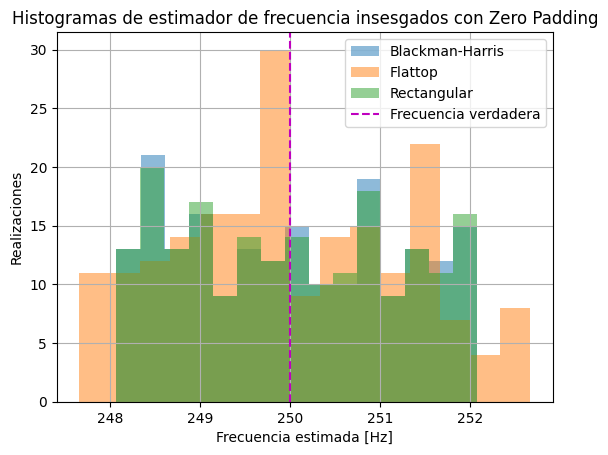

In [10]:
plt.figure()
plt.hist(f_estimado_1_xn_1_w_bh_zp-sesgo_f_bh_zp, bins, alpha=0.5, label='Blackman-Harris')
plt.hist(f_estimado_1_xn_1_w_flattop_zp-sesgo_f_flattop_zp, bins, alpha=0.5, label='Flattop')
plt.hist(f_estimado_1_xn_1_w_rectangular_zp-sesgo_f_rectangular_zp, bins, alpha=0.5, label='Rectangular')
plt.axvline(np.mean(f_real), color='m', linestyle='--', label='Frecuencia verdadera') # Línea vertical indicando valor verdadero de frecuencia promedio
plt.title("Histogramas de estimador de frecuencia insesgados con Zero Padding")
plt.xlabel("Frecuencia estimada [Hz]")
plt.ylabel("Realizaciones")
plt.legend()
plt.grid()
plt.show()

Se confirma gráficamente como es que mejorar la resolución espectral mediante el método de Zero Padding sirve definitivamente para mejorar las estimaciones con ventanas, pasando de ser "barras" que estiman valores en rangos distanciados a ser una especie de "nube" o una "densidad" de estimaciones en un rango cercano al valor real a estimar, obteniendo así, un histograma más descriptivo para poder realizar una mejor comparativa entre las ventanas.

Gracias al Zero Padding puede observarse como ventanas como la rectangular mejoran significativamente su estimación en frecuencia, mientras que ventanas como la Flattop mantienen (o incluso empeoran un poco) sus estimaciones.

# Conclusiones




# Autoevaluación
A) Sí, resolvimos la tarea con seguridad.

B) Lo aprendido en esta tarea fue +++

C) No fue usada.